# **1.Import the Dependencies**

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')
import tensorflow as tf
import keras
from keras.layers import Conv2D, Dense, Flatten, Reshape, LeakyReLU, Dropout, UpSampling2D,BatchNormalization
from keras.models import Sequential
import tensorflow_datasets as tfds
import os
from keras.preprocessing.image import array_to_img
from keras.callbacks import Callback

E0000 00:00:1734270731.367565      13 common_lib.cc:798] Could not set metric server port: INVALID_ARGUMENT: Could not find SliceBuilder port 8471 in any of the 0 ports provided in `tpu_process_addresses`="local"
=== Source Location Trace: ===
learning/45eac/tfrc/runtime/common_lib.cc:479
D1215 13:52:11.375862466      13 config.cc:196]                        gRPC EXPERIMENT call_status_override_on_cancellation   OFF (default:OFF)
D1215 13:52:11.375876882      13 config.cc:196]                        gRPC EXPERIMENT call_v3                                OFF (default:OFF)
D1215 13:52:11.375880252      13 config.cc:196]                        gRPC EXPERIMENT canary_client_privacy                  ON  (default:ON)
D1215 13:52:11.375882911      13 config.cc:196]                        gRPC EXPERIMENT capture_base_context                   ON  (default:ON)
D1215 13:52:11.375885251      13 config.cc:196]                        gRPC EXPERIMENT client_idleness                        ON  (defau

# ****2.Download the CIFAR10 dataset****

In [2]:
ds = tfds.load('cifar10', split='train')

Dl Completed...: 0 url [00:00, ? url/s]
Dl Size...: 0 MiB [00:00, ? MiB/s]

Dl Completed...:   0%|          | 0/1 [00:00<?, ? url/s]
Dl Size...: 0 MiB [00:00, ? MiB/s]

Dl Size...:   0%|          | 0/162 [00:00<?, ? MiB/s]

Dl Size...:   1%|          | 1/162 [00:00<02:15,  1.18 MiB/s]

Dl Size...:   1%|          | 2/162 [00:00<01:14,  2.14 MiB/s]

Dl Size...:   2%|▏         | 3/162 [00:00<00:50,  3.16 MiB/s]

Extraction completed...: 0 file [00:00, ? file/s]
Dl Size...:   2%|▏         | 4/162 [00:01<00:40,  3.88 MiB/s]

Dl Size...:   3%|▎         | 5/162 [00:01<00:40,  3.88 MiB/s]

Dl Size...:   4%|▎         | 6/162 [00:01<00:40,  3.88 MiB/s]

Dl Size...:   4%|▍         | 7/162 [00:01<00:39,  3.88 MiB/s]

Dl Size...:   5%|▍         | 8/162 [00:01<00:39,  3.88 MiB/s]

Dl Size...:   6%|▌         | 9/162 [00:01<00:39,  3.88 MiB/s]

Dl Size...:   6%|▌         | 10/162 [00:01<00:39,  3.88 MiB/s]

Dl Size...:   7%|▋         | 11/162 [00:01<00:38,  3.88 MiB/s]

Dl Size...:   7%|▋         | 12

Dataset cifar10 downloaded and prepared to /root/tensorflow_datasets/cifar10/3.0.2. Subsequent calls will reuse this data.


# ****3.Data visualization and data preprocessing****

In [3]:
dataiterator = ds.as_numpy_iterator()

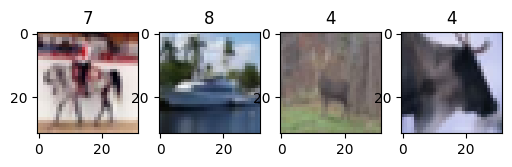

In [4]:
fig,ax = plt.subplots(ncols=4 ,figsize=(6,6) )

for i in range(4):
    sample = dataiterator.next()
    ax[i].imshow(sample['image'])
    ax[i].title.set_text(sample['label'])

In [5]:
# model preprocessing
def scale(img):
  img=(img['image'])
  return img/255

In [6]:
ds = tfds.load('cifar10', split='train')
ds = ds.map(scale)
ds = ds.cache()
ds = ds.shuffle(50000)
ds = ds.batch(128)
ds = ds.prefetch(64)   # helps for faster fetching of data

In [7]:
ds.as_numpy_iterator().next().shape

(128, 32, 32, 3)

# **4.Model creation**

In [8]:
def NN_generator():
    model = Sequential()

    model.add(Dense(8 * 8 * 256, input_dim=128))
    model.add(LeakyReLU(0.2))
    model.add(Reshape((8, 8, 256)))

    model.add(UpSampling2D())
    model.add(Conv2D(128,4,padding='same'))
    model.add(LeakyReLU(0.2))

    model.add(UpSampling2D())
    model.add(Conv2D(128,4,padding='same'))
    model.add(LeakyReLU(0.2))

    model.add(Conv2D(128,4,padding='same'))
    model.add(LeakyReLU(0.2))

    model.add(Conv2D(128,4,padding='same'))
    model.add(LeakyReLU(0.2))

    model.add(Conv2D(3, 4, padding='same', activation='sigmoid')) # use of tanh takes more time to process but tend to work well in generator

    return model

In [9]:
generator = NN_generator()

In [10]:
generator.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense (Dense)                   │ (None, 16384)          │     2,113,536 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu (LeakyReLU)         │ (None, 16384)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ reshape (Reshape)               │ (None, 8, 8, 256)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ up_sampling2d (UpSampling2D)    │ (None, 16, 16, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ (None, 16, 16, 128)    │       524,416 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_1 (LeakyReLU)       │ (None, 16, 16, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ up_sampling2d_1 (UpSampling2D)  │ (None, 32, 32, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 32, 32, 128)    │       262,272 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_2 (LeakyReLU)       │ (None, 32, 32, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 32, 32, 128)    │       262,272 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_3 (LeakyReLU)       │ (None, 32, 32, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 32, 32, 128)    │       262,272 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_4 (LeakyReLU)       │ (None, 32, 32, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 32, 32, 3)      │         6,147 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 3,430,915 (13.09 MB)

 Trainable params: 3,430,915 (13.09 MB)

 Non-trainable params: 0 (0.00 B)

In [18]:
img = generator.predict(tf.random.normal((4, 128,1)))

fig, ax = plt.subplots(ncols=4, figsize=(7, 7))

for idx, img in enumerate(img):
    ax[idx].imshow(np.squeeze(img))
    ax[idx].title.set_text(idx)

plt.show()

NotFoundError: Graph execution error:

Detected at node StatefulPartitionedCall defined at (most recent call last):
  File "/usr/local/lib/python3.10/runpy.py", line 196, in _run_module_as_main

  File "/usr/local/lib/python3.10/runpy.py", line 86, in _run_code

  File "/usr/local/lib/python3.10/site-packages/ipykernel_launcher.py", line 18, in <module>

  File "/usr/local/lib/python3.10/site-packages/traitlets/config/application.py", line 1075, in launch_instance

  File "/usr/local/lib/python3.10/site-packages/ipykernel/kernelapp.py", line 739, in start

  File "/usr/local/lib/python3.10/site-packages/tornado/platform/asyncio.py", line 205, in start

  File "/usr/local/lib/python3.10/asyncio/base_events.py", line 603, in run_forever

  File "/usr/local/lib/python3.10/asyncio/base_events.py", line 1909, in _run_once

  File "/usr/local/lib/python3.10/asyncio/events.py", line 80, in _run

  File "/usr/local/lib/python3.10/site-packages/ipykernel/kernelbase.py", line 545, in dispatch_queue

  File "/usr/local/lib/python3.10/site-packages/ipykernel/kernelbase.py", line 534, in process_one

  File "/usr/local/lib/python3.10/site-packages/ipykernel/kernelbase.py", line 437, in dispatch_shell

  File "/usr/local/lib/python3.10/site-packages/ipykernel/ipkernel.py", line 362, in execute_request

  File "/usr/local/lib/python3.10/site-packages/ipykernel/kernelbase.py", line 778, in execute_request

  File "/usr/local/lib/python3.10/site-packages/ipykernel/ipkernel.py", line 449, in do_execute

  File "/usr/local/lib/python3.10/site-packages/ipykernel/zmqshell.py", line 549, in run_cell

  File "/usr/local/lib/python3.10/site-packages/IPython/core/interactiveshell.py", line 3075, in run_cell

  File "/usr/local/lib/python3.10/site-packages/IPython/core/interactiveshell.py", line 3130, in _run_cell

  File "/usr/local/lib/python3.10/site-packages/IPython/core/async_helpers.py", line 128, in _pseudo_sync_runner

  File "/usr/local/lib/python3.10/site-packages/IPython/core/interactiveshell.py", line 3334, in run_cell_async

  File "/usr/local/lib/python3.10/site-packages/IPython/core/interactiveshell.py", line 3517, in run_ast_nodes

  File "/usr/local/lib/python3.10/site-packages/IPython/core/interactiveshell.py", line 3577, in run_code

  File "/tmp/ipykernel_13/4001015226.py", line 1, in <module>

  File "/usr/local/lib/python3.10/site-packages/keras/src/utils/traceback_utils.py", line 117, in error_handler

  File "/usr/local/lib/python3.10/site-packages/keras/src/backend/tensorflow/trainer.py", line 510, in predict

  File "/usr/local/lib/python3.10/site-packages/keras/src/backend/tensorflow/trainer.py", line 208, in one_step_on_data_distributed

could not find registered transfer manager for platform Host -- check target linkage
	 [[{{node StatefulPartitionedCall}}]] [Op:__inference_one_step_on_data_distributed_120568]

In [ ]:
def NN_discriminator():
    model = Sequential()

    model.add(Conv2D(32,4,strides=2, padding='same', input_shape=(32, 32, 3)))
    model.add(LeakyReLU(0.2))
    model.add(Dropout(0.3))

    model.add(Conv2D(64,4,strides=2,padding='same'))
    model.add(LeakyReLU(0.2))
    model.add(Dropout(0.3))

    model.add(Conv2D(128,4,strides=2,padding='same'))
    model.add(LeakyReLU(0.2))
    model.add(Dropout(0.3))

    model.add(Conv2D(256, 4,strides=2,padding='same'))
    model.add(LeakyReLU(0.2))
    model.add(Dropout(0.3))

    model.add(Flatten())
    model.add(Dense(1, activation='sigmoid'))

    return model

In [34]:
discriminator = NN_discriminator()

In [35]:
discriminator.summary()

Model: "sequential_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d_13 (Conv2D)                   │ (None, 16, 16, 32)          │           1,568 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ leaky_re_lu_14 (LeakyReLU)           │ (None, 16, 16, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_4 (Dropout)                  │ (None, 16, 16, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_14 (Conv2D)                   │ (None, 8, 8, 64)            │          32,832 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ leaky_re_lu_15 (LeakyReLU)           │ (None, 8, 8, 64)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_5 (Dropout)                  │ (None, 8, 8, 64)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_15 (Conv2D)                   │ (None, 4, 4, 128)           │         131,200 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ leaky_re_lu_16 (LeakyReLU)           │ (None, 4, 4, 128)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_6 (Dropout)                  │ (None, 4, 4, 128)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_1 (Flatten)                  │ (None, 2048)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_4 (Dense)                      │ (None, 1)                   │           2,049 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 167,649 (654.88 KB)

 Trainable params: 167,649 (654.88 KB)

 Non-trainable params: 0 (0.00 B)

In [36]:
img = img.reshape(1,32,32,3)

In [37]:
discriminator.predict(img)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 433ms/step


array([[0.47690076]], dtype=float32)

# **5.Define the Optimizer and the loss function**

In [38]:
from keras.optimizers import Adam
from keras.losses import BinaryCrossentropy as bc

In [39]:
g_opt = Adam(learning_rate=0.0001)
d_opt = Adam(learning_rate=0.00001)

g_loss = bc()
d_loss = bc()

In [40]:
from keras.models import Model

In [41]:
class GAN(Model):
  def __init__(self,generator,discriminator,*args,**kwargs):
    super().__init__(*args,**kwargs)

    self.discriminator = discriminator
    self.generator = generator

  def compile(self,g_opt,d_opt,g_loss,d_loss,*args,**kwargs):
    super().compile(*args,**kwargs)

    self.g_opt = g_opt
    self.d_opt = d_opt
    self.g_loss = g_loss
    self.d_loss = d_loss

  def train_step(self, batch):

    real_img = batch
    fake_img = self.generator(tf.random.normal((128,128,1)),training=False)

    with tf.GradientTape() as d_tape:
      yhat_real = self.discriminator(real_img,training=True)
      yhat_fake = self.discriminator(fake_img,training=True)
      yhat_realfake = tf.concat([yhat_real,yhat_fake],axis=0)

      y_realfake = tf.concat([tf.zeros_like(yhat_real),tf.ones_like(yhat_fake)],axis=0)

      noise_real = 0.15*tf.random.uniform(tf.shape(yhat_real))
      noise_fake = -0.15*tf.random.uniform(tf.shape(yhat_fake))
      y_realfake += tf.concat([noise_real,noise_fake],axis=0)

      tot_d_loss = self.d_loss(y_realfake,yhat_realfake)

      dgrad = d_tape.gradient(tot_d_loss,self.discriminator.trainable_variables)
      self.d_opt.apply_gradients(zip(dgrad,self.discriminator.trainable_variables))

    with tf.GradientTape() as g_tape:
      gen_img = self.generator(tf.random.normal((128,128,1)),training=True)

      pred_labels = self.discriminator(gen_img,training=False)

      tot_g_loss = self.g_loss(tf.zeros_like(pred_labels),pred_labels)

      ggrad = g_tape.gradient(tot_g_loss,self.generator.trainable_variables)
      self.g_opt.apply_gradients(zip(ggrad,self.generator.trainable_variables))

    return {"d_loss":tot_d_loss,"g_loss":tot_g_loss}

In [42]:
gan = GAN(generator,discriminator)

In [43]:
gan.compile(g_opt,d_opt,g_loss,d_loss)

# 6. **use Callback** to store the image produces during each epocs

In [44]:
class ModelMonitor(Callback):
    def __init__(self, num_img=3, latent_dim=128):
        self.num_img = num_img
        self.latent_dim = latent_dim

    def on_epoch_end(self, epoch, logs=None):
        random_latent_vectors = tf.random.uniform((self.num_img, self.latent_dim,1))
        generated_images = self.model.generator(random_latent_vectors)
        generated_images *= 255
        generated_images.numpy()
        for i in range(self.num_img):
            img = array_to_img(generated_images[i])
            img.save(os.path.join('/content/drive/MyDrive/images', f'generated_img_{epoch}_{i}.png'))

In [ ]:
hist = gan.fit(ds, epochs=20,callbacks=[ModelMonitor()])

# **7.Performance**

In [ ]:
plt.suptitle('Loss')
plt.plot(hist.history['d_loss'], label='d_loss')
plt.plot(hist.history['g_loss'], label='g_loss')
plt.legend()
plt.show()

# **8.Save the models**

In [ ]:
generator.save("generator.h5")
discriminator.save("discriminator.h5")